# CNN Experiments with Flowers Dataset

In [2]:
import os
print(os.listdir('/Users/tashrifrayhan/Documents/DLA2/flowers'))

['.DS_Store', 'daisy', 'rose', 'tulip', 'dandelion', 'sunflower']


<a id="content1"></a>
## 1 ) Importing Various Modules.

In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
! pip install tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
! pip install opencv-python
import cv2
import numpy as np
from tqdm import tqdm
import os
from random import shuffle
from zipfile import ZipFile
from PIL import Image

<a id="content2"></a>
## 2 ) Preparing the Data

## 2.1) Making the functions to get the training, validation and test set from the Images

In [4]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='/Users/tashrifrayhan/Documents/DLA2/flowers/daisy'
FLOWER_SUNFLOWER_DIR='/Users/tashrifrayhan/Documents/DLA2/flowers/sunflower'
FLOWER_TULIP_DIR='/Users/tashrifrayhan/Documents/DLA2/flowers/tulip'
FLOWER_DANDI_DIR='/Users/tashrifrayhan/Documents/DLA2/flowers/dandelion'
FLOWER_ROSE_DIR='/Users/tashrifrayhan/Documents/DLA2/flowers/rose'

In [5]:
def assign_label(img,flower_type):
    return flower_type


In [6]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

        X.append(np.array(img))
        Z.append(str(label))


In [7]:
make_train_data('daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|███████████████████████████████████████| 764/764 [00:00<00:00, 1100.86it/s]

764


In [8]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|████████████████████████████████████████| 733/733 [00:00<00:00, 835.43it/s]

1497


In [9]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|████████████████████████████████████████| 984/984 [00:00<00:00, 988.86it/s]

2481


In [10]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|█████████████████████████████████████| 1052/1052 [00:00<00:00, 1071.03it/s]

3533


In [11]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|███████████████████████████████████████| 784/784 [00:00<00:00, 1082.72it/s]

4317


## 2.2 ) Visualizing some Random Images

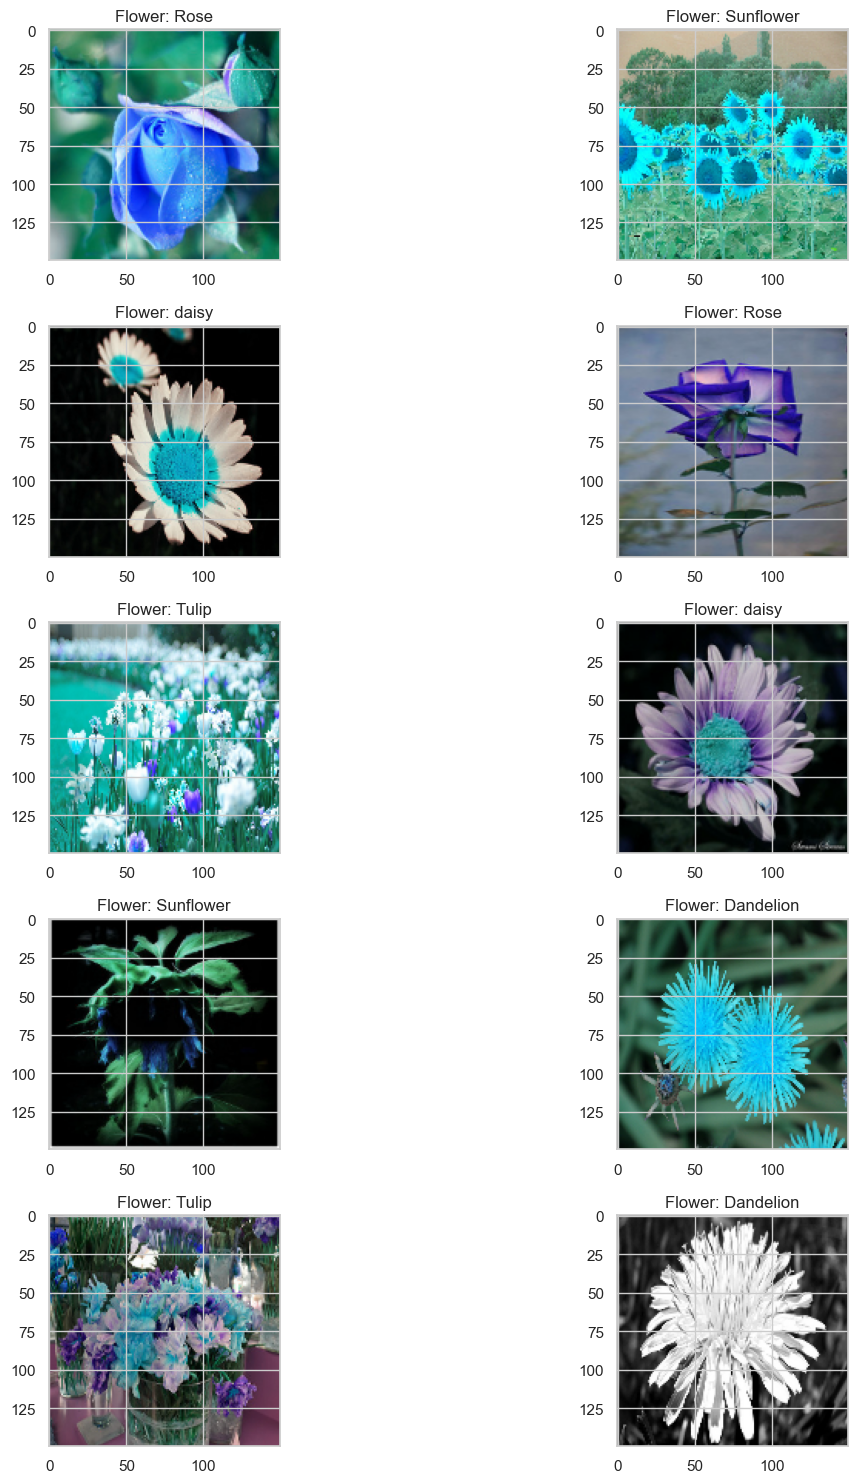

In [12]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])

plt.tight_layout()


## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [13]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

## 2.4 ) Splitting into Training and Validation Sets

In [15]:
# Split into training (70%), validation (15%), and test (15%) sets
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

## 2.5 ) Setting the Random Seeds

In [16]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

<a id="content3"></a>
## 3 ) Modelling

## 3.1 ) Building the ConvNet Model

In [17]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))


model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

## 3.2 ) Using a LR Annealer

In [96]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1)

## 3.4 ) Compiling the Keras Model & Summary

In [20]:
model.compile(optimizer=Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 96)        0

## 3.5 ) Fitting on the Training set and making predcitons on the Validation set

In [22]:
# History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (x_test,y_test),
#                               verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
History = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(x_val,y_val), verbose=1, callbacks=[red_lr])
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 3.0827 - accuracy: 0.2307WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 24s 963ms/step - loss: 3.0827 - accuracy: 0.2307 - val_loss: 1.5903 - val_accuracy: 0.2191 - lr: 0.0100
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 1.5378 - accuracy: 0.3025WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 22s 929ms/step - loss: 1.5378 - accuracy: 0.3025 - val_loss: 1.4839 - val_accuracy: 0.3488 - lr: 0.0100
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 1.4887 - accuracy: 0.3313WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 23s 945ms/step - loss: 1.4887 - accuracy: 0.3313 - val_loss: 1.4466 - val_accuracy: 0.3627 - lr: 0.0100
Epoch 4/50
24/24 [==============================] - ETA: 0s - loss: 1.4135 - accuracy: 0.3717WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 23s 949ms/step - loss: 1.4135 - accuracy: 0.3717 - val_loss: 1.3788 - val_accuracy: 0.3889 - lr: 0.0100
Epoch 5/50
24/24 [==============================] - ETA: 0s - loss: 1.3425 - accuracy: 0.4244WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 24s 982ms/step - loss: 1.3425 - accuracy: 0.4244 - val_loss: 1.3462 - val_accuracy: 0.3812 - lr: 0.0100
Epoch 6/50
24/24 [==============================] - ETA: 0s - loss: 1.2739 - accuracy: 0.4528WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 24s 980ms/step - loss: 1.2739 - accuracy: 0.4528 - val_loss: 1.4320 - val_accuracy: 0.3812 - lr: 0.0100
Epoch 7/50
24/24 [==============================] - ETA: 0s - loss: 1.2734 - accuracy: 0.4568WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 24s 982ms/step - loss: 1.2734 - accuracy: 0.4568 - val_loss: 1.3349 - val_accuracy: 0.4167 - lr: 0.0100
Epoch 8/50
24/24 [==============================] - ETA: 0s - loss: 1.2328 - accuracy: 0.4773WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 24s 981ms/step - loss: 1.2328 - accuracy: 0.4773 - val_loss: 1.3476 - val_accuracy: 0.4151 - lr: 0.0100
Epoch 9/50
24/24 [==============================] - ETA: 0s - loss: 1.1687 - accuracy: 0.5157WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 24s 982ms/step - loss: 1.1687 - accuracy: 0.5157 - val_loss: 1.2353 - val_accuracy: 0.4753 - lr: 0.0100
Epoch 10/50
24/24 [==============================] - ETA: 0s - loss: 1.1336 - accuracy: 0.5270WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 23s 980ms/step - loss: 1.1336 - accuracy: 0.5270 - val_loss: 1.2835 - val_accuracy: 0.4383 - lr: 0.0100
Epoch 11/50
24/24 [==============================] - ETA: 0s - loss: 1.1528 - accuracy: 0.5270WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 24s 990ms/step - loss: 1.1528 - accuracy: 0.5270 - val_loss: 1.2386 - val_accuracy: 0.4815 - lr: 0.0100
Epoch 12/50
24/24 [==============================] - ETA: 0s - loss: 1.0867 - accuracy: 0.5641WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 24s 1s/step - loss: 1.0867 - accuracy: 0.5641 - val_loss: 1.1791 - val_accuracy: 0.5093 - lr: 0.0100
Epoch 13/50
24/24 [==============================] - ETA: 0s - loss: 1.0408 - accuracy: 0.5631WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 26s 1s/step - loss: 1.0408 - accuracy: 0.5631 - val_loss: 1.1604 - val_accuracy: 0.5262 - lr: 0.0100
Epoch 14/50
24/24 [==============================] - ETA: 0s - loss: 1.0049 - accuracy: 0.5885WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 1.0049 - accuracy: 0.5885 - val_loss: 1.1822 - val_accuracy: 0.5170 - lr: 0.0100
Epoch 15/50
24/24 [==============================] - ETA: 0s - loss: 0.9344 - accuracy: 0.6319WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.9344 - accuracy: 0.6319 - val_loss: 1.1395 - val_accuracy: 0.5309 - lr: 0.0100
Epoch 16/50
24/24 [==============================] - ETA: 0s - loss: 0.9010 - accuracy: 0.6402WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.9010 - accuracy: 0.6402 - val_loss: 1.1329 - val_accuracy: 0.5648 - lr: 0.0100
Epoch 17/50
24/24 [==============================] - ETA: 0s - loss: 0.7851 - accuracy: 0.6812WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.7851 - accuracy: 0.6812 - val_loss: 1.1418 - val_accuracy: 0.5509 - lr: 0.0100
Epoch 18/50
24/24 [==============================] - ETA: 0s - loss: 0.7536 - accuracy: 0.7094WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.7536 - accuracy: 0.7094 - val_loss: 1.1944 - val_accuracy: 0.5494 - lr: 0.0100
Epoch 19/50
24/24 [==============================] - ETA: 0s - loss: 0.6468 - accuracy: 0.7597WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 26s 1s/step - loss: 0.6468 - accuracy: 0.7597 - val_loss: 1.3426 - val_accuracy: 0.5556 - lr: 0.0100
Epoch 20/50
24/24 [==============================] - ETA: 0s - loss: 0.5925 - accuracy: 0.7762WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 26s 1s/step - loss: 0.5925 - accuracy: 0.7762 - val_loss: 1.2685 - val_accuracy: 0.5633 - lr: 0.0100
Epoch 21/50
24/24 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.7918WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.5535 - accuracy: 0.7918 - val_loss: 1.5993 - val_accuracy: 0.5201 - lr: 0.0100
Epoch 22/50
24/24 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.8295WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.4544 - accuracy: 0.8295 - val_loss: 1.7053 - val_accuracy: 0.5478 - lr: 0.0100
Epoch 23/50
24/24 [==============================] - ETA: 0s - loss: 0.3833 - accuracy: 0.8663WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.3833 - accuracy: 0.8663 - val_loss: 1.5977 - val_accuracy: 0.5355 - lr: 0.0100
Epoch 24/50
24/24 [==============================] - ETA: 0s - loss: 0.3331 - accuracy: 0.8825WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.3331 - accuracy: 0.8825 - val_loss: 2.2153 - val_accuracy: 0.5478 - lr: 0.0100
Epoch 25/50
24/24 [==============================] - ETA: 0s - loss: 0.2669 - accuracy: 0.9126WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 28s 1s/step - loss: 0.2669 - accuracy: 0.9126 - val_loss: 2.1425 - val_accuracy: 0.5448 - lr: 0.0100
Epoch 26/50
24/24 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9331WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 28s 1s/step - loss: 0.2067 - accuracy: 0.9331 - val_loss: 2.2538 - val_accuracy: 0.5355 - lr: 0.0100
Epoch 27/50
24/24 [==============================] - ETA: 0s - loss: 0.1697 - accuracy: 0.9474WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.1697 - accuracy: 0.9474 - val_loss: 2.5506 - val_accuracy: 0.5355 - lr: 0.0100
Epoch 28/50
24/24 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9563WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.1494 - accuracy: 0.9563 - val_loss: 3.2132 - val_accuracy: 0.5478 - lr: 0.0100
Epoch 29/50
24/24 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9305WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 28s 1s/step - loss: 0.2090 - accuracy: 0.9305 - val_loss: 2.6837 - val_accuracy: 0.5340 - lr: 0.0100
Epoch 30/50
24/24 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9503WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 28s 1s/step - loss: 0.1535 - accuracy: 0.9503 - val_loss: 2.9964 - val_accuracy: 0.5201 - lr: 0.0100
Epoch 31/50
24/24 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.9560WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 28s 1s/step - loss: 0.1361 - accuracy: 0.9560 - val_loss: 3.3001 - val_accuracy: 0.5139 - lr: 0.0100
Epoch 32/50
24/24 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 0.9563WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 28s 1s/step - loss: 0.1576 - accuracy: 0.9563 - val_loss: 3.3333 - val_accuracy: 0.5370 - lr: 0.0100
Epoch 33/50
24/24 [==============================] - ETA: 0s - loss: 0.2185 - accuracy: 0.9245WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 28s 1s/step - loss: 0.2185 - accuracy: 0.9245 - val_loss: 3.0734 - val_accuracy: 0.5201 - lr: 0.0100
Epoch 34/50
24/24 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9454WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 29s 1s/step - loss: 0.1707 - accuracy: 0.9454 - val_loss: 3.1340 - val_accuracy: 0.5278 - lr: 0.0100
Epoch 35/50
24/24 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9689WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.1158 - accuracy: 0.9689 - val_loss: 3.5760 - val_accuracy: 0.5216 - lr: 0.0100
Epoch 36/50
24/24 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9626WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.1130 - accuracy: 0.9626 - val_loss: 3.5814 - val_accuracy: 0.5340 - lr: 0.0100
Epoch 37/50
24/24 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9861WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.0606 - accuracy: 0.9861 - val_loss: 3.7766 - val_accuracy: 0.5185 - lr: 0.0100
Epoch 38/50
24/24 [==============================] - ETA: 0s - loss: 0.0403 - accuracy: 0.9894WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.0403 - accuracy: 0.9894 - val_loss: 4.2439 - val_accuracy: 0.5278 - lr: 0.0100
Epoch 39/50
24/24 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9897WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.0382 - accuracy: 0.9897 - val_loss: 4.1427 - val_accuracy: 0.5062 - lr: 0.0100
Epoch 40/50
24/24 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9911WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 28s 1s/step - loss: 0.0342 - accuracy: 0.9911 - val_loss: 4.2848 - val_accuracy: 0.5386 - lr: 0.0100
Epoch 41/50
24/24 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9917WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 29s 1s/step - loss: 0.0325 - accuracy: 0.9917 - val_loss: 4.3391 - val_accuracy: 0.5216 - lr: 0.0100
Epoch 42/50
24/24 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9924WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 30s 1s/step - loss: 0.0294 - accuracy: 0.9924 - val_loss: 4.9580 - val_accuracy: 0.5432 - lr: 0.0100
Epoch 43/50
24/24 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9957WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 31s 1s/step - loss: 0.0201 - accuracy: 0.9957 - val_loss: 5.0373 - val_accuracy: 0.5247 - lr: 0.0100
Epoch 44/50
24/24 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9907WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 29s 1s/step - loss: 0.0332 - accuracy: 0.9907 - val_loss: 4.9723 - val_accuracy: 0.5355 - lr: 0.0100
Epoch 45/50
24/24 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.9623WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 28s 1s/step - loss: 0.1375 - accuracy: 0.9623 - val_loss: 4.0195 - val_accuracy: 0.5123 - lr: 0.0100
Epoch 46/50
24/24 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9441WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 28s 1s/step - loss: 0.1734 - accuracy: 0.9441 - val_loss: 3.8343 - val_accuracy: 0.5216 - lr: 0.0100
Epoch 47/50
24/24 [==============================] - ETA: 0s - loss: 0.2121 - accuracy: 0.9361WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.2121 - accuracy: 0.9361 - val_loss: 3.7435 - val_accuracy: 0.5216 - lr: 0.0100
Epoch 48/50
24/24 [==============================] - ETA: 0s - loss: 0.2153 - accuracy: 0.9292WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 27s 1s/step - loss: 0.2153 - accuracy: 0.9292 - val_loss: 4.8312 - val_accuracy: 0.5077 - lr: 0.0100
Epoch 49/50
24/24 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9338WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 28s 1s/step - loss: 0.2205 - accuracy: 0.9338 - val_loss: 4.4747 - val_accuracy: 0.5185 - lr: 0.0100
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.1257 - accuracy: 0.9570WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


24/24 [==============================] - 28s 1s/step - loss: 0.1257 - accuracy: 0.9570 - val_loss: 4.0178 - val_accuracy: 0.5000 - lr: 0.0100


<a id="content4"></a>
## 4 ) Evaluating the Model Performance

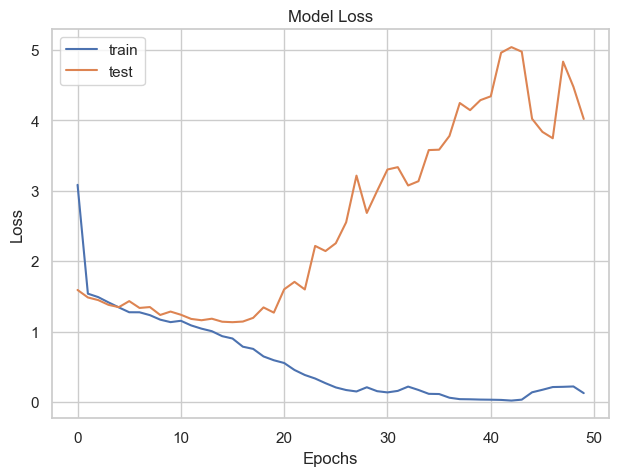

In [23]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

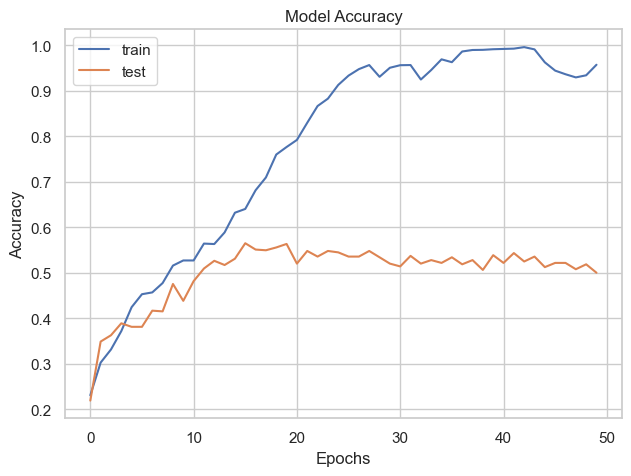

In [24]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [25]:
def display_evaluation_metrics(History, epoch = -1):
    print("The BASELINE CNN model with dropout has the following performance outcomes for the 50th epoch:\n")
    print("Training accuracy:", History.history['accuracy'][epoch])
    print("Training loss:", History.history['loss'][epoch])
    print("Validation accuracy:", History.history['val_accuracy'][epoch])
    print("Validation loss:", History.history['val_loss'][epoch])

In [89]:
display_evaluation_metrics(History)

The CNN model with VGG 19 Architecture has the following performance outcomes for the 50th epoch:

Training accuracy: 0.9569678902626038
Training loss: 0.12568873167037964
Validation accuracy: 0.5
Validation loss: 4.017810821533203


In [28]:
#Experiment 1: Adding a dropout layer (25%)

from keras.layers import Dropout

# Initialize a new Sequential model
model_with_dropout = Sequential()

# Add the first Conv2D and MaxPooling2D layers as in original model
model_with_dropout.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(150, 150, 3)))
model_with_dropout.add(MaxPooling2D(pool_size=(2, 2)))
model_with_dropout.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model_with_dropout.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_with_dropout.add(Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu'))
model_with_dropout.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Add a Dropout layer with a 25% dropout rate
model_with_dropout.add(Dropout(0.25))

# Add the rest of layers (Conv2D, MaxPooling2D, Flatten, Dense) as in original model
model_with_dropout.add(Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu'))
model_with_dropout.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_with_dropout.add(Flatten())
model_with_dropout.add(Dense(512))
model_with_dropout.add(Activation('relu'))
model_with_dropout.add(Dense(5, activation='softmax'))

In [29]:
# Compile the model as before
model_with_dropout.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_with_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 18, 18, 96)       

In [32]:
# Fit the model with dropout on the training data, including data augmentation
History_with_dropout = model_with_dropout.fit(x_train, y_train, batch_size=batch_size,
                                                        epochs=epochs, validation_data=(x_val, y_val),
                                                        verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
                                                        callbacks=[red_lr])

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 6.1206 - accuracy: 0.2330WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 23s 971ms/step - loss: 6.1206 - accuracy: 0.2330 - val_loss: 1.5865 - val_accuracy: 0.2315 - lr: 0.0100
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.5185 - accuracy: 0.3035WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 21s 950ms/step - loss: 1.5185 - accuracy: 0.3035 - val_loss: 1.4905 - val_accuracy: 0.3534 - lr: 0.0100
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.4706 - accuracy: 0.3450WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 22s 955ms/step - loss: 1.4706 - accuracy: 0.3450 - val_loss: 1.5043 - val_accuracy: 0.3426 - lr: 0.0100
Epoch 4/50
23/23 [==============================] - ETA: 0s - loss: 1.4499 - accuracy: 0.3705WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 22s 974ms/step - loss: 1.4499 - accuracy: 0.3705 - val_loss: 1.5604 - val_accuracy: 0.3025 - lr: 0.0100
Epoch 5/50
23/23 [==============================] - ETA: 0s - loss: 1.4294 - accuracy: 0.3640WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 23s 1s/step - loss: 1.4294 - accuracy: 0.3640 - val_loss: 1.6104 - val_accuracy: 0.2639 - lr: 0.0100
Epoch 6/50
23/23 [==============================] - ETA: 0s - loss: 1.3787 - accuracy: 0.3972WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 23s 991ms/step - loss: 1.3787 - accuracy: 0.3972 - val_loss: 1.4319 - val_accuracy: 0.3627 - lr: 0.0100
Epoch 7/50
23/23 [==============================] - ETA: 0s - loss: 1.3209 - accuracy: 0.4238WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 23s 994ms/step - loss: 1.3209 - accuracy: 0.4238 - val_loss: 1.4235 - val_accuracy: 0.3951 - lr: 0.0100
Epoch 8/50
23/23 [==============================] - ETA: 0s - loss: 1.2369 - accuracy: 0.4905WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 23s 1s/step - loss: 1.2369 - accuracy: 0.4905 - val_loss: 1.4205 - val_accuracy: 0.4244 - lr: 0.0100
Epoch 9/50
23/23 [==============================] - ETA: 0s - loss: 1.1982 - accuracy: 0.5026WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 23s 1s/step - loss: 1.1982 - accuracy: 0.5026 - val_loss: 1.5028 - val_accuracy: 0.3657 - lr: 0.0100
Epoch 10/50
23/23 [==============================] - ETA: 0s - loss: 1.1628 - accuracy: 0.5226WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 23s 1s/step - loss: 1.1628 - accuracy: 0.5226 - val_loss: 1.4417 - val_accuracy: 0.4090 - lr: 0.0100
Epoch 11/50
23/23 [==============================] - ETA: 0s - loss: 1.1708 - accuracy: 0.5237WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 23s 1s/step - loss: 1.1708 - accuracy: 0.5237 - val_loss: 1.2727 - val_accuracy: 0.4799 - lr: 0.0100
Epoch 12/50
23/23 [==============================] - ETA: 0s - loss: 1.1008 - accuracy: 0.5555WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 24s 1s/step - loss: 1.1008 - accuracy: 0.5555 - val_loss: 1.2978 - val_accuracy: 0.4506 - lr: 0.0100
Epoch 13/50
23/23 [==============================] - ETA: 0s - loss: 1.0329 - accuracy: 0.5790WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 1.0329 - accuracy: 0.5790 - val_loss: 1.3286 - val_accuracy: 0.4769 - lr: 0.0100
Epoch 14/50
23/23 [==============================] - ETA: 0s - loss: 0.9662 - accuracy: 0.6160WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.9662 - accuracy: 0.6160 - val_loss: 1.3088 - val_accuracy: 0.4722 - lr: 0.0100
Epoch 15/50
23/23 [==============================] - ETA: 0s - loss: 0.9226 - accuracy: 0.6502WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.9226 - accuracy: 0.6502 - val_loss: 1.3180 - val_accuracy: 0.4630 - lr: 0.0100
Epoch 16/50
23/23 [==============================] - ETA: 0s - loss: 0.8386 - accuracy: 0.6768WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.8386 - accuracy: 0.6768 - val_loss: 1.3521 - val_accuracy: 0.4491 - lr: 0.0100
Epoch 17/50
23/23 [==============================] - ETA: 0s - loss: 0.8037 - accuracy: 0.6834WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.8037 - accuracy: 0.6834 - val_loss: 1.3752 - val_accuracy: 0.4630 - lr: 0.0100
Epoch 18/50
23/23 [==============================] - ETA: 0s - loss: 0.7305 - accuracy: 0.7103WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.7305 - accuracy: 0.7103 - val_loss: 1.3960 - val_accuracy: 0.4738 - lr: 0.0100
Epoch 19/50
23/23 [==============================] - ETA: 0s - loss: 0.6657 - accuracy: 0.7511WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.6657 - accuracy: 0.7511 - val_loss: 1.5911 - val_accuracy: 0.4244 - lr: 0.0100
Epoch 20/50
23/23 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.7715WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.6219 - accuracy: 0.7715 - val_loss: 1.5729 - val_accuracy: 0.4537 - lr: 0.0100
Epoch 21/50
23/23 [==============================] - ETA: 0s - loss: 0.5703 - accuracy: 0.7923WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.5703 - accuracy: 0.7923 - val_loss: 1.6057 - val_accuracy: 0.4707 - lr: 0.0100
Epoch 22/50
23/23 [==============================] - ETA: 0s - loss: 0.6011 - accuracy: 0.7684WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.6011 - accuracy: 0.7684 - val_loss: 1.8328 - val_accuracy: 0.4892 - lr: 0.0100
Epoch 23/50
23/23 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.8033WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.5459 - accuracy: 0.8033 - val_loss: 1.8321 - val_accuracy: 0.4645 - lr: 0.0100
Epoch 24/50
23/23 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.8303WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.4792 - accuracy: 0.8303 - val_loss: 1.5513 - val_accuracy: 0.5031 - lr: 0.0100
Epoch 25/50
23/23 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.8380WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.4418 - accuracy: 0.8380 - val_loss: 1.8516 - val_accuracy: 0.4784 - lr: 0.0100
Epoch 26/50
23/23 [==============================] - ETA: 0s - loss: 0.4293 - accuracy: 0.8365WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.4293 - accuracy: 0.8365 - val_loss: 1.9019 - val_accuracy: 0.4769 - lr: 0.0100
Epoch 27/50
23/23 [==============================] - ETA: 0s - loss: 0.3705 - accuracy: 0.8718WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.3705 - accuracy: 0.8718 - val_loss: 2.0688 - val_accuracy: 0.4614 - lr: 0.0100
Epoch 28/50
23/23 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.8635WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.3661 - accuracy: 0.8635 - val_loss: 1.8604 - val_accuracy: 0.4969 - lr: 0.0100
Epoch 29/50
23/23 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.8804WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.3407 - accuracy: 0.8804 - val_loss: 1.9403 - val_accuracy: 0.4969 - lr: 0.0100
Epoch 30/50
23/23 [==============================] - ETA: 0s - loss: 0.2699 - accuracy: 0.9001WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.2699 - accuracy: 0.9001 - val_loss: 2.1690 - val_accuracy: 0.5108 - lr: 0.0100
Epoch 31/50
23/23 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.9015WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.2962 - accuracy: 0.9015 - val_loss: 1.9327 - val_accuracy: 0.5216 - lr: 0.0100
Epoch 32/50
23/23 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.9004WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.2839 - accuracy: 0.9004 - val_loss: 2.4346 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 33/50
23/23 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.9025WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.2818 - accuracy: 0.9025 - val_loss: 2.2416 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 34/50
23/23 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.9143WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.2675 - accuracy: 0.9143 - val_loss: 2.3675 - val_accuracy: 0.4722 - lr: 0.0100
Epoch 35/50
23/23 [==============================] - ETA: 0s - loss: 0.2330 - accuracy: 0.9253WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.2330 - accuracy: 0.9253 - val_loss: 2.5451 - val_accuracy: 0.4722 - lr: 0.0100
Epoch 36/50
23/23 [==============================] - ETA: 0s - loss: 0.2183 - accuracy: 0.9229WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.2183 - accuracy: 0.9229 - val_loss: 2.2947 - val_accuracy: 0.5062 - lr: 0.0100
Epoch 37/50
23/23 [==============================] - ETA: 0s - loss: 0.2106 - accuracy: 0.9271WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.2106 - accuracy: 0.9271 - val_loss: 2.9196 - val_accuracy: 0.4861 - lr: 0.0100
Epoch 38/50
23/23 [==============================] - ETA: 0s - loss: 0.1926 - accuracy: 0.9347WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.1926 - accuracy: 0.9347 - val_loss: 2.5508 - val_accuracy: 0.4969 - lr: 0.0100
Epoch 39/50
23/23 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.9264WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.2191 - accuracy: 0.9264 - val_loss: 2.8250 - val_accuracy: 0.4583 - lr: 0.0100
Epoch 40/50
23/23 [==============================] - ETA: 0s - loss: 0.1883 - accuracy: 0.9405WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.1883 - accuracy: 0.9405 - val_loss: 2.4529 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 41/50
23/23 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9361WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.2220 - accuracy: 0.9361 - val_loss: 2.8784 - val_accuracy: 0.4691 - lr: 0.0100
Epoch 42/50
23/23 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9215WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.2352 - accuracy: 0.9215 - val_loss: 2.7805 - val_accuracy: 0.4676 - lr: 0.0100
Epoch 43/50
23/23 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9409WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.1850 - accuracy: 0.9409 - val_loss: 2.4751 - val_accuracy: 0.4907 - lr: 0.0100
Epoch 44/50
23/23 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9485WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.1546 - accuracy: 0.9485 - val_loss: 2.6019 - val_accuracy: 0.4892 - lr: 0.0100
Epoch 45/50
23/23 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9623WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.1207 - accuracy: 0.9623 - val_loss: 2.5204 - val_accuracy: 0.5231 - lr: 0.0100
Epoch 46/50
23/23 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9558WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.1412 - accuracy: 0.9558 - val_loss: 2.7262 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 47/50
23/23 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9492WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.1556 - accuracy: 0.9492 - val_loss: 2.6203 - val_accuracy: 0.5046 - lr: 0.0100
Epoch 48/50
23/23 [==============================] - ETA: 0s - loss: 0.1362 - accuracy: 0.9537WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.1362 - accuracy: 0.9537 - val_loss: 2.7849 - val_accuracy: 0.5216 - lr: 0.0100
Epoch 49/50
23/23 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9412WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.2014 - accuracy: 0.9412 - val_loss: 2.3362 - val_accuracy: 0.4923 - lr: 0.0100
Epoch 50/50
23/23 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9502WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.1753 - accuracy: 0.9502 - val_loss: 2.8246 - val_accuracy: 0.5015 - lr: 0.0100


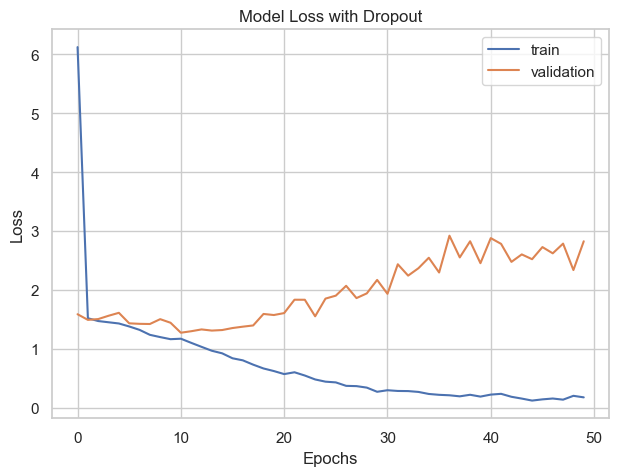

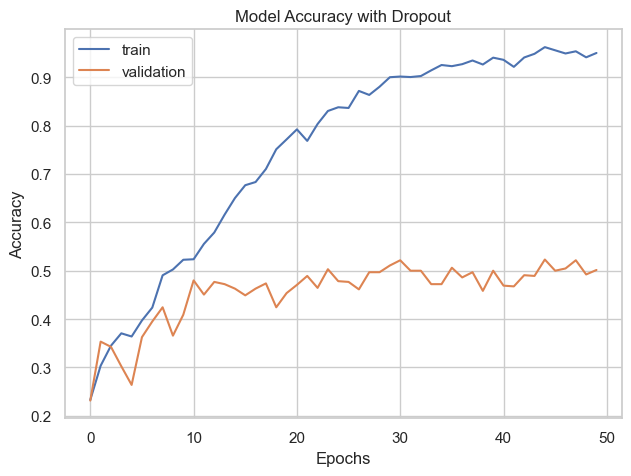

In [34]:
# Evaluating the Model Performance
import matplotlib.pyplot as plt

# Plot the loss
plt.plot(History_with_dropout.history['loss'])
plt.plot(History_with_dropout.history['val_loss'])
plt.title('Model Loss with Dropout')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Plot the accuracy
plt.plot(History_with_dropout.history['accuracy'])
plt.plot(History_with_dropout.history['val_accuracy'])
plt.title('Model Accuracy with Dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [35]:
def display_evaluation_metrics(History_with_dropout, epoch = -1):
    print("The CNN model with dropout has the following performance outcomes for the 50th epoch:\n")
    print("Training accuracy:", History_with_dropout.history['accuracy'][epoch])
    print("Training loss:", History_with_dropout.history['loss'][epoch])
    print("Validation accuracy:", History_with_dropout.history['val_accuracy'][epoch])
    print("Validation loss:", History_with_dropout.history['val_loss'][epoch])

In [90]:
display_evaluation_metrics(History_with_dropout)

The CNN model with VGG 19 Architecture has the following performance outcomes for the 50th epoch:

Training accuracy: 0.9502246975898743
Training loss: 0.17532823979854584
Validation accuracy: 0.5015432238578796
Validation loss: 2.8246169090270996


In [37]:
# Experiment 2: Adding BatchNormalization

from keras.layers import BatchNormalization

# Initialize a new Sequential model for Experiment 2
model_with_batchnorm = Sequential()

# Add the first Conv2D and MaxPooling2D layers as in original model
model_with_batchnorm.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(150, 150, 3)))
model_with_batchnorm.add(MaxPooling2D(pool_size=(2, 2)))
model_with_batchnorm.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model_with_batchnorm.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_with_batchnorm.add(Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu'))
model_with_batchnorm.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Add Batch Normalization after the first Conv2D layer
model_with_batchnorm.add(BatchNormalization())

# Continue with the rest of the layers as in original model
model_with_batchnorm.add(Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu'))
model_with_batchnorm.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_with_batchnorm.add(Flatten())
model_with_batchnorm.add(Dense(512))
model_with_batchnorm.add(Activation('relu'))
model_with_batchnorm.add(Dense(5, activation='softmax'))


In [38]:
# Compile the model with Batch Normalization
model_with_batchnorm.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture with Batch Normalization
model_with_batchnorm.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 18, 18, 96)       

In [39]:
# Fit the model with Batch Normalization on the training data, including data augmentation
History_with_batchnorm = model_with_batchnorm.fit(x_train, y_train, batch_size=batch_size,
                                                            epochs=epochs, validation_data=(x_val, y_val),
                                                            verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
                                                            callbacks=[red_lr])

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 2.9796 - accuracy: 0.2728WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 24s 1s/step - loss: 2.9796 - accuracy: 0.2728 - val_loss: 1.6047 - val_accuracy: 0.3380 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.2121 - accuracy: 0.4860WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 23s 1s/step - loss: 1.2121 - accuracy: 0.4860 - val_loss: 1.5889 - val_accuracy: 0.4367 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.0700 - accuracy: 0.5700WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 23s 996ms/step - loss: 1.0700 - accuracy: 0.5700 - val_loss: 1.5809 - val_accuracy: 0.4738 - lr: 0.0010
Epoch 4/50
23/23 [==============================] - ETA: 0s - loss: 0.9769 - accuracy: 0.6149WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 23s 1s/step - loss: 0.9769 - accuracy: 0.6149 - val_loss: 1.5701 - val_accuracy: 0.4213 - lr: 0.0010
Epoch 5/50
23/23 [==============================] - ETA: 0s - loss: 0.8962 - accuracy: 0.6426WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 24s 1s/step - loss: 0.8962 - accuracy: 0.6426 - val_loss: 1.5440 - val_accuracy: 0.4830 - lr: 0.0010
Epoch 6/50
23/23 [==============================] - ETA: 0s - loss: 0.8378 - accuracy: 0.6882WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 25s 1s/step - loss: 0.8378 - accuracy: 0.6882 - val_loss: 1.5226 - val_accuracy: 0.5123 - lr: 0.0010
Epoch 7/50
23/23 [==============================] - ETA: 0s - loss: 0.8119 - accuracy: 0.6782WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 24s 1s/step - loss: 0.8119 - accuracy: 0.6782 - val_loss: 1.5284 - val_accuracy: 0.4784 - lr: 0.0010
Epoch 8/50
23/23 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.7172WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 25s 1s/step - loss: 0.7277 - accuracy: 0.7172 - val_loss: 1.5088 - val_accuracy: 0.5278 - lr: 0.0010
Epoch 9/50
23/23 [==============================] - ETA: 0s - loss: 0.6678 - accuracy: 0.7490WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.6678 - accuracy: 0.7490 - val_loss: 1.4493 - val_accuracy: 0.5494 - lr: 0.0010
Epoch 10/50
23/23 [==============================] - ETA: 0s - loss: 0.6212 - accuracy: 0.7649WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.6212 - accuracy: 0.7649 - val_loss: 1.4201 - val_accuracy: 0.5432 - lr: 0.0010
Epoch 11/50
23/23 [==============================] - ETA: 0s - loss: 0.5786 - accuracy: 0.7902WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.5786 - accuracy: 0.7902 - val_loss: 1.3507 - val_accuracy: 0.4892 - lr: 0.0010
Epoch 12/50
23/23 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.8341WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.4671 - accuracy: 0.8341 - val_loss: 1.2195 - val_accuracy: 0.6296 - lr: 0.0010
Epoch 13/50
23/23 [==============================] - ETA: 0s - loss: 0.4482 - accuracy: 0.8358WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.4482 - accuracy: 0.8358 - val_loss: 1.1832 - val_accuracy: 0.6265 - lr: 0.0010
Epoch 14/50
23/23 [==============================] - ETA: 0s - loss: 0.3725 - accuracy: 0.8659WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.3725 - accuracy: 0.8659 - val_loss: 1.1323 - val_accuracy: 0.6003 - lr: 0.0010
Epoch 15/50
23/23 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.8870WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 29s 1s/step - loss: 0.3255 - accuracy: 0.8870 - val_loss: 1.0672 - val_accuracy: 0.6173 - lr: 0.0010
Epoch 16/50
23/23 [==============================] - ETA: 0s - loss: 0.2632 - accuracy: 0.9081WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.2632 - accuracy: 0.9081 - val_loss: 0.9101 - val_accuracy: 0.6620 - lr: 0.0010
Epoch 17/50
23/23 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 0.9426WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.2030 - accuracy: 0.9426 - val_loss: 0.9268 - val_accuracy: 0.6343 - lr: 0.0010
Epoch 18/50
23/23 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9599WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.1514 - accuracy: 0.9599 - val_loss: 0.9924 - val_accuracy: 0.6049 - lr: 0.0010
Epoch 19/50
23/23 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9551WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 29s 1s/step - loss: 0.1540 - accuracy: 0.9551 - val_loss: 0.8739 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 20/50
23/23 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9672WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.1240 - accuracy: 0.9672 - val_loss: 0.8868 - val_accuracy: 0.6806 - lr: 0.0010
Epoch 21/50
23/23 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9838WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.0746 - accuracy: 0.9838 - val_loss: 0.9221 - val_accuracy: 0.6744 - lr: 0.0010
Epoch 22/50
23/23 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.9882WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.0644 - accuracy: 0.9882 - val_loss: 1.1927 - val_accuracy: 0.6543 - lr: 0.0010
Epoch 23/50
23/23 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9907WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.0506 - accuracy: 0.9907 - val_loss: 1.1915 - val_accuracy: 0.6404 - lr: 0.0010
Epoch 24/50
23/23 [==============================] - ETA: 0s - loss: 0.0354 - accuracy: 0.9972WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.0354 - accuracy: 0.9972 - val_loss: 1.1715 - val_accuracy: 0.6698 - lr: 0.0010
Epoch 25/50
23/23 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9949WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.0322 - accuracy: 0.9949 - val_loss: 1.4100 - val_accuracy: 0.6327 - lr: 0.0010
Epoch 26/50
23/23 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9948WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.0358 - accuracy: 0.9948 - val_loss: 1.4951 - val_accuracy: 0.6543 - lr: 0.0010
Epoch 27/50
23/23 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9979WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.0248 - accuracy: 0.9979 - val_loss: 1.2999 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 28/50
23/23 [==============================] - ETA: 0s - loss: 0.0130 - accuracy: 0.9993WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 32s 1s/step - loss: 0.0130 - accuracy: 0.9993 - val_loss: 1.4025 - val_accuracy: 0.6728 - lr: 0.0010
Epoch 29/50
23/23 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0134 - accuracy: 0.9990 - val_loss: 1.4544 - val_accuracy: 0.6790 - lr: 0.0010
Epoch 30/50
23/23 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0118 - accuracy: 0.9990 - val_loss: 1.5124 - val_accuracy: 0.6821 - lr: 0.0010
Epoch 31/50
23/23 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9997WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 30s 1s/step - loss: 0.0055 - accuracy: 0.9997 - val_loss: 1.5322 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 32/50
23/23 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9997WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 30s 1s/step - loss: 0.0086 - accuracy: 0.9997 - val_loss: 1.5213 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 33/50
23/23 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0117 - accuracy: 0.9990 - val_loss: 1.6584 - val_accuracy: 0.6713 - lr: 0.0010
Epoch 34/50
23/23 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9983WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0155 - accuracy: 0.9983 - val_loss: 1.6679 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 35/50
23/23 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9758WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 30s 1s/step - loss: 0.0682 - accuracy: 0.9758 - val_loss: 1.8703 - val_accuracy: 0.6451 - lr: 0.0010
Epoch 36/50
23/23 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9668WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.1156 - accuracy: 0.9668 - val_loss: 1.4915 - val_accuracy: 0.6543 - lr: 0.0010
Epoch 37/50
23/23 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9748WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.0881 - accuracy: 0.9748 - val_loss: 1.6171 - val_accuracy: 0.6451 - lr: 0.0010
Epoch 38/50
23/23 [==============================] - ETA: 0s - loss: 0.0448 - accuracy: 0.9900WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.0448 - accuracy: 0.9900 - val_loss: 1.9744 - val_accuracy: 0.6559 - lr: 0.0010
Epoch 39/50
23/23 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9952WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.0268 - accuracy: 0.9952 - val_loss: 1.7732 - val_accuracy: 0.6698 - lr: 0.0010
Epoch 40/50
23/23 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9993WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.0109 - accuracy: 0.9993 - val_loss: 1.7234 - val_accuracy: 0.6806 - lr: 0.0010
Epoch 41/50
23/23 [==============================] - ETA: 0s - loss: 0.0076 - accuracy: 0.9986WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.0076 - accuracy: 0.9986 - val_loss: 1.6632 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 42/50
23/23 [==============================] - ETA: 0s - loss: 0.0074 - accuracy: 0.9986WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 29s 1s/step - loss: 0.0074 - accuracy: 0.9986 - val_loss: 1.8435 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 43/50
23/23 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 29s 1s/step - loss: 0.0064 - accuracy: 0.9990 - val_loss: 1.7393 - val_accuracy: 0.7006 - lr: 0.0010
Epoch 44/50
23/23 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9993WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 32s 1s/step - loss: 0.0067 - accuracy: 0.9993 - val_loss: 1.7539 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 45/50
23/23 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 33s 1s/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 1.7329 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 46/50
23/23 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 33s 1s/step - loss: 0.0070 - accuracy: 0.9990 - val_loss: 1.7478 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 47/50
23/23 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9997WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 39s 2s/step - loss: 0.0034 - accuracy: 0.9997 - val_loss: 1.7185 - val_accuracy: 0.6836 - lr: 0.0010
Epoch 48/50
23/23 [==============================] - ETA: 0s - loss: 0.0075 - accuracy: 0.9986WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 30s 1s/step - loss: 0.0075 - accuracy: 0.9986 - val_loss: 1.7711 - val_accuracy: 0.6883 - lr: 0.0010
Epoch 49/50
23/23 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9986WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 30s 1s/step - loss: 0.0065 - accuracy: 0.9986 - val_loss: 1.7791 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 50/50
23/23 [==============================] - ETA: 0s - loss: 0.0070 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 37s 2s/step - loss: 0.0070 - accuracy: 0.9990 - val_loss: 1.6951 - val_accuracy: 0.6821 - lr: 0.0010


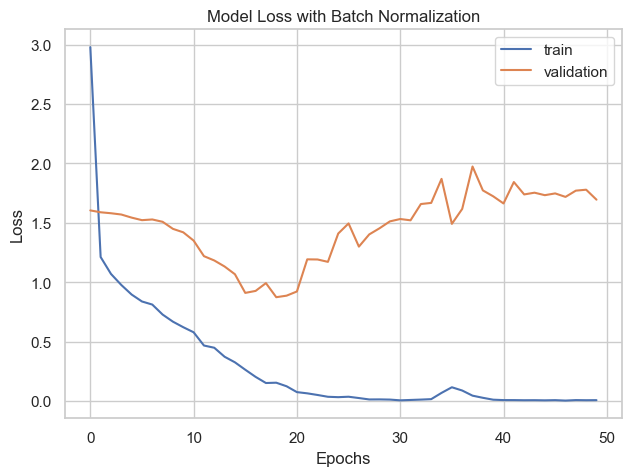

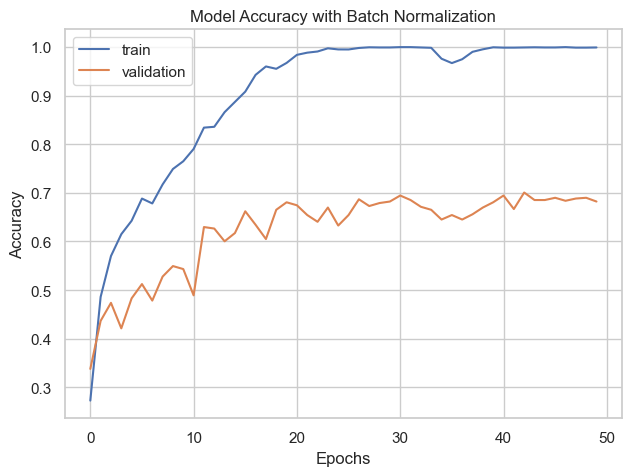

In [41]:
# Evaluation of Model Performance
# Plot the loss
plt.plot(History_with_batchnorm.history['loss'])
plt.plot(History_with_batchnorm.history['val_loss'])
plt.title('Model Loss with Batch Normalization')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Plot the accuracy
plt.plot(History_with_batchnorm.history['accuracy'])
plt.plot(History_with_batchnorm.history['val_accuracy'])
plt.title('Model Accuracy with Batch Normalization')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [92]:
def display_evaluation_metrics(History_with_batchnorm, epoch = -1):
    print("The CNN model with batchnormalization has the following performance outcomes for the 50th epoch:\n")
    print("Training accuracy:", History_with_batchnorm.history['accuracy'][epoch])
    print("Training loss:", History_with_batchnorm.history['loss'][epoch])
    print("Validation accuracy:", History_with_batchnorm.history['val_accuracy'][epoch])
    print("Validation loss:", History_with_batchnorm.history['val_loss'][epoch])

In [93]:
display_evaluation_metrics(History_with_batchnorm)

The CNN model with batchnormalization has the following performance outcomes for the 50th epoch:

Training accuracy: 0.9989629983901978
Training loss: 0.007006285712122917
Validation accuracy: 0.6820987462997437
Validation loss: 1.6951218843460083


In [44]:
#Experiment 3: Adding both dropout layer and batchnormalization

# Initialize a new Sequential model for Experiment 3
model_with_dropout_and_batchnorm = Sequential()

# Add the first Conv2D and MaxPooling2D layers as in your original model
model_with_dropout_and_batchnorm.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', 
                                            input_shape=(150, 150, 3)))
model_with_dropout_and_batchnorm.add(MaxPooling2D(pool_size=(2, 2)))

# Add Batch Normalization after the first Conv2D layer
model_with_dropout_and_batchnorm.add(BatchNormalization())

# Add a Dropout layer with a 25% dropout rate
model_with_dropout_and_batchnorm.add(Dropout(0.25))

# Continue with the rest of the layers as in your original model
model_with_dropout_and_batchnorm.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model_with_dropout_and_batchnorm.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_with_dropout_and_batchnorm.add(Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu'))
model_with_dropout_and_batchnorm.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_with_dropout_and_batchnorm.add(Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu'))
model_with_dropout_and_batchnorm.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_with_dropout_and_batchnorm.add(Flatten())
model_with_dropout_and_batchnorm.add(Dense(512))
model_with_dropout_and_batchnorm.add(Activation('relu'))
model_with_dropout_and_batchnorm.add(Dense(5, activation='softmax'))

In [45]:
# Compile the model with both Dropout and Batch Normalization
model_with_dropout_and_batchnorm.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
# Summary of the model architecture with both Dropout and Batch Normalization
model_with_dropout_and_batchnorm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 37, 37, 64)       

In [50]:
# Fit the model with both Dropout and Batch Normalization on the training data, including data augmentation
History_with_dropout_and_batchnorm = model_with_dropout_and_batchnorm.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val),
                                                                                  verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
                                                                                  callbacks=[red_lr])

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 2.2485 - accuracy: 0.3179WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 24s 1s/step - loss: 2.2485 - accuracy: 0.3179 - val_loss: 1.5598 - val_accuracy: 0.3488 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.1987 - accuracy: 0.5126WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 25s 1s/step - loss: 1.1987 - accuracy: 0.5126 - val_loss: 1.5349 - val_accuracy: 0.3549 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.0724 - accuracy: 0.5610WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 1.0724 - accuracy: 0.5610 - val_loss: 1.5036 - val_accuracy: 0.3951 - lr: 0.0010
Epoch 4/50
23/23 [==============================] - ETA: 0s - loss: 0.9947 - accuracy: 0.6008WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.9947 - accuracy: 0.6008 - val_loss: 1.4967 - val_accuracy: 0.3117 - lr: 0.0010
Epoch 5/50
23/23 [==============================] - ETA: 0s - loss: 0.9420 - accuracy: 0.6281WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.9420 - accuracy: 0.6281 - val_loss: 1.4444 - val_accuracy: 0.4568 - lr: 0.0010
Epoch 6/50
23/23 [==============================] - ETA: 0s - loss: 0.8925 - accuracy: 0.6533WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 26s 1s/step - loss: 0.8925 - accuracy: 0.6533 - val_loss: 1.4000 - val_accuracy: 0.5247 - lr: 0.0010
Epoch 7/50
23/23 [==============================] - ETA: 0s - loss: 0.8240 - accuracy: 0.6782WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 27s 1s/step - loss: 0.8240 - accuracy: 0.6782 - val_loss: 1.3376 - val_accuracy: 0.5571 - lr: 0.0010
Epoch 8/50
23/23 [==============================] - ETA: 0s - loss: 0.7707 - accuracy: 0.7069WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.7707 - accuracy: 0.7069 - val_loss: 1.3877 - val_accuracy: 0.4182 - lr: 0.0010
Epoch 9/50
23/23 [==============================] - ETA: 0s - loss: 0.7133 - accuracy: 0.7425WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 28s 1s/step - loss: 0.7133 - accuracy: 0.7425 - val_loss: 1.2233 - val_accuracy: 0.5602 - lr: 0.0010
Epoch 10/50
23/23 [==============================] - ETA: 0s - loss: 0.6383 - accuracy: 0.7681WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.6383 - accuracy: 0.7681 - val_loss: 1.1393 - val_accuracy: 0.5787 - lr: 0.0010
Epoch 11/50
23/23 [==============================] - ETA: 0s - loss: 0.5907 - accuracy: 0.7764WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.5907 - accuracy: 0.7764 - val_loss: 1.0966 - val_accuracy: 0.5941 - lr: 0.0010
Epoch 12/50
23/23 [==============================] - ETA: 0s - loss: 0.4955 - accuracy: 0.8234WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 30s 1s/step - loss: 0.4955 - accuracy: 0.8234 - val_loss: 1.0796 - val_accuracy: 0.5710 - lr: 0.0010
Epoch 13/50
23/23 [==============================] - ETA: 0s - loss: 0.4357 - accuracy: 0.8431WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 32s 1s/step - loss: 0.4357 - accuracy: 0.8431 - val_loss: 1.0467 - val_accuracy: 0.5864 - lr: 0.0010
Epoch 14/50
23/23 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.8745WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.3412 - accuracy: 0.8745 - val_loss: 1.1746 - val_accuracy: 0.5355 - lr: 0.0010
Epoch 15/50
23/23 [==============================] - ETA: 0s - loss: 0.2867 - accuracy: 0.8946WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 29s 1s/step - loss: 0.2867 - accuracy: 0.8946 - val_loss: 1.0531 - val_accuracy: 0.5586 - lr: 0.0010
Epoch 16/50
23/23 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 0.9357WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 30s 1s/step - loss: 0.2030 - accuracy: 0.9357 - val_loss: 1.1092 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 17/50
23/23 [==============================] - ETA: 0s - loss: 0.1946 - accuracy: 0.9374WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 32s 1s/step - loss: 0.1946 - accuracy: 0.9374 - val_loss: 1.1696 - val_accuracy: 0.5910 - lr: 0.0010
Epoch 18/50
23/23 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.9623WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 33s 1s/step - loss: 0.1202 - accuracy: 0.9623 - val_loss: 1.2246 - val_accuracy: 0.5895 - lr: 0.0010
Epoch 19/50
23/23 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.9723WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 32s 1s/step - loss: 0.0906 - accuracy: 0.9723 - val_loss: 1.4053 - val_accuracy: 0.5802 - lr: 0.0010
Epoch 20/50
23/23 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.9765WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0834 - accuracy: 0.9765 - val_loss: 1.4802 - val_accuracy: 0.5864 - lr: 0.0010
Epoch 21/50
23/23 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9800WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 30s 1s/step - loss: 0.0710 - accuracy: 0.9800 - val_loss: 1.6205 - val_accuracy: 0.5710 - lr: 0.0010
Epoch 22/50
23/23 [==============================] - ETA: 0s - loss: 0.0699 - accuracy: 0.9782WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 29s 1s/step - loss: 0.0699 - accuracy: 0.9782 - val_loss: 1.5999 - val_accuracy: 0.5756 - lr: 0.0010
Epoch 23/50
23/23 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9786WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 29s 1s/step - loss: 0.0725 - accuracy: 0.9786 - val_loss: 1.5717 - val_accuracy: 0.5880 - lr: 0.0010
Epoch 24/50
23/23 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9813WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0618 - accuracy: 0.9813 - val_loss: 1.7570 - val_accuracy: 0.5972 - lr: 0.0010
Epoch 25/50
23/23 [==============================] - ETA: 0s - loss: 0.0417 - accuracy: 0.9888WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0417 - accuracy: 0.9888 - val_loss: 1.9657 - val_accuracy: 0.6111 - lr: 0.0010
Epoch 26/50
23/23 [==============================] - ETA: 0s - loss: 0.0269 - accuracy: 0.9927WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 32s 1s/step - loss: 0.0269 - accuracy: 0.9927 - val_loss: 2.1237 - val_accuracy: 0.6019 - lr: 0.0010
Epoch 27/50
23/23 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9965WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 33s 1s/step - loss: 0.0152 - accuracy: 0.9965 - val_loss: 2.2005 - val_accuracy: 0.5988 - lr: 0.0010
Epoch 28/50
23/23 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9986WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0093 - accuracy: 0.9986 - val_loss: 2.2654 - val_accuracy: 0.6127 - lr: 0.0010
Epoch 29/50
23/23 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 33s 1s/step - loss: 0.0080 - accuracy: 0.9990 - val_loss: 2.3219 - val_accuracy: 0.5941 - lr: 0.0010
Epoch 30/50
23/23 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9969WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0159 - accuracy: 0.9969 - val_loss: 2.3412 - val_accuracy: 0.5957 - lr: 0.0010
Epoch 31/50
23/23 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9969WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0114 - accuracy: 0.9969 - val_loss: 2.3695 - val_accuracy: 0.5448 - lr: 0.0010
Epoch 32/50
23/23 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9896WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 32s 1s/step - loss: 0.0389 - accuracy: 0.9896 - val_loss: 2.4080 - val_accuracy: 0.5540 - lr: 0.0010
Epoch 33/50
23/23 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9934WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 32s 1s/step - loss: 0.0214 - accuracy: 0.9934 - val_loss: 2.4771 - val_accuracy: 0.5725 - lr: 0.0010
Epoch 34/50
23/23 [==============================] - ETA: 0s - loss: 0.0394 - accuracy: 0.9896WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0394 - accuracy: 0.9896 - val_loss: 2.4236 - val_accuracy: 0.5262 - lr: 0.0010
Epoch 35/50
23/23 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9900WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0332 - accuracy: 0.9900 - val_loss: 2.4273 - val_accuracy: 0.5787 - lr: 0.0010
Epoch 36/50
23/23 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.9924WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 32s 1s/step - loss: 0.0363 - accuracy: 0.9924 - val_loss: 2.4247 - val_accuracy: 0.5633 - lr: 0.0010
Epoch 37/50
23/23 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9941WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0221 - accuracy: 0.9941 - val_loss: 2.5448 - val_accuracy: 0.5895 - lr: 0.0010
Epoch 38/50
23/23 [==============================] - ETA: 0s - loss: 0.0112 - accuracy: 0.9969WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 34s 1s/step - loss: 0.0112 - accuracy: 0.9969 - val_loss: 2.6380 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 39/50
23/23 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 32s 1s/step - loss: 0.0089 - accuracy: 0.9990 - val_loss: 2.5869 - val_accuracy: 0.5710 - lr: 0.0010
Epoch 40/50
23/23 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0062 - accuracy: 0.9990 - val_loss: 2.5776 - val_accuracy: 0.5895 - lr: 0.0010
Epoch 41/50
23/23 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9993WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0051 - accuracy: 0.9993 - val_loss: 2.5019 - val_accuracy: 0.5849 - lr: 0.0010
Epoch 42/50
23/23 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9986WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 32s 1s/step - loss: 0.0053 - accuracy: 0.9986 - val_loss: 2.5265 - val_accuracy: 0.5910 - lr: 0.0010
Epoch 43/50
23/23 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9993WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 33s 1s/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 2.5716 - val_accuracy: 0.5895 - lr: 0.0010
Epoch 44/50
23/23 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9993WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0036 - accuracy: 0.9993 - val_loss: 2.5920 - val_accuracy: 0.5864 - lr: 0.0010
Epoch 45/50
23/23 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 2.5156 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 46/50
23/23 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9993WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 30s 1s/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 2.5254 - val_accuracy: 0.5864 - lr: 0.0010
Epoch 47/50
23/23 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 0.9993WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 32s 1s/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 2.5797 - val_accuracy: 0.5988 - lr: 0.0010
Epoch 48/50
23/23 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 31s 1s/step - loss: 0.0051 - accuracy: 0.9990 - val_loss: 2.5616 - val_accuracy: 0.5895 - lr: 0.0010
Epoch 49/50
23/23 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 32s 1s/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 2.5615 - val_accuracy: 0.6003 - lr: 0.0010
Epoch 50/50
23/23 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9990WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 34s 2s/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 2.5510 - val_accuracy: 0.5910 - lr: 0.0010


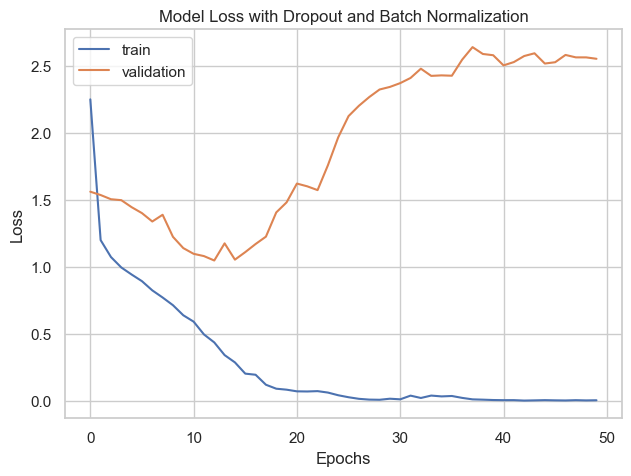

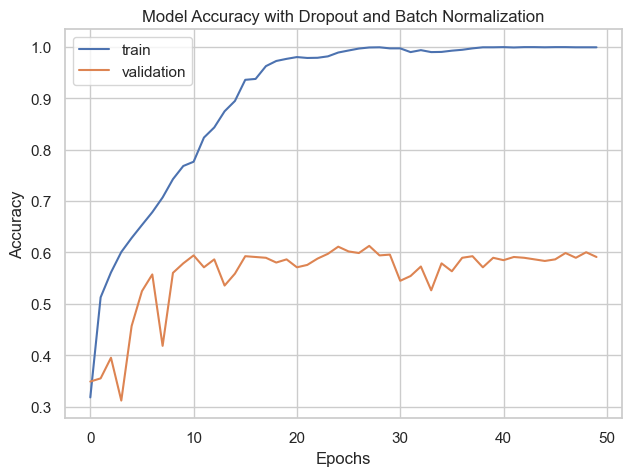

In [52]:
#Evaluating the Model Performance for Experiment 3

# Plot the loss
plt.plot(History_with_dropout_and_batchnorm.history['loss'])
plt.plot(History_with_dropout_and_batchnorm.history['val_loss'])
plt.title('Model Loss with Dropout and Batch Normalization')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Plot the accuracy
plt.plot(History_with_dropout_and_batchnorm.history['accuracy'])
plt.plot(History_with_dropout_and_batchnorm.history['val_accuracy'])
plt.title('Model Accuracy with Dropout and Batch Normalization')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [53]:
def display_evaluation_metrics(History_with_dropout_and_batchnorm, epoch = -1):
    print("The CNN model with batchnormalization has the following performance outcomes for the 50th epoch:\n")
    print("Training accuracy:", History_with_dropout_and_batchnorm.history['accuracy'][epoch])
    print("Training loss:", History_with_dropout_and_batchnorm.history['loss'][epoch])
    print("Validation accuracy:", History_with_dropout_and_batchnorm.history['val_accuracy'][epoch])
    print("Validation loss:", History_with_dropout_and_batchnorm.history['val_loss'][epoch])

In [55]:
display_evaluation_metrics(History_with_dropout_and_batchnorm, epoch=49)

The CNN model with batchnormalization has the following performance outcomes for the 50th epoch:

Training accuracy: 0.9989629983901978
Training loss: 0.004419906996190548
Validation accuracy: 0.5910493731498718
Validation loss: 2.5510239601135254


In [58]:
#Experiment 4: Including Data Augmentation

from keras.preprocessing.image import ImageDataGenerator

# Initialize a new Sequential model
model_with_data_augmentation = Sequential()

# Add the first Conv2D and MaxPooling2D layers as in the original model
model_with_data_augmentation.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', 
                                        input_shape=(150, 150, 3)))
model_with_data_augmentation.add(MaxPooling2D(pool_size=(2, 2)))
model_with_data_augmentation.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model_with_data_augmentation.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_with_data_augmentation.add(Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu'))
model_with_data_augmentation.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Apply data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(x_train)

# Add the rest of the layers (Conv2D, MaxPooling2D, Flatten, Dense) as in the original model
model_with_data_augmentation.add(Conv2D(filters=96, kernel_size=(3, 3), padding='Same', activation='relu'))
model_with_data_augmentation.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_with_data_augmentation.add(Flatten())
model_with_data_augmentation.add(Dense(512))
model_with_data_augmentation.add(Activation('relu'))
model_with_data_augmentation.add(Dense(5, activation='softmax'))

In [59]:
# Compile the model as before
model_with_data_augmentation.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_with_data_augmentation.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 37, 37, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 18, 18, 96)       

In [97]:
# Fit the model with data augmentation on the training data
History_with_data_augmentation = model_with_batchnorm.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(x_train) / batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    verbose=1,
    callbacks=[red_lr]
)

Epoch 1/50
23/23 [==============================] - 24s 1s/step - loss: 0.7346 - accuracy: 0.7163 - val_loss: 0.8490 - val_accuracy: 0.6620 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - 25s 1s/step - loss: 0.6939 - accuracy: 0.7461 - val_loss: 0.7608 - val_accuracy: 0.7052 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - 25s 1s/step - loss: 0.7066 - accuracy: 0.7309 - val_loss: 0.8149 - val_accuracy: 0.6883 - lr: 0.0010
Epoch 4/50
23/23 [==============================] - 26s 1s/step - loss: 0.6947 - accuracy: 0.7349 - val_loss: 0.7538 - val_accuracy: 0.7191 - lr: 0.0010
Epoch 5/50
23/23 [==============================] - 26s 1s/step - loss: 0.6758 - accuracy: 0.7431 - val_loss: 0.8116 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 6/50
23/23 [==============================] - 27s 1s/step - loss: 0.6527 - accuracy: 0.7421 - val_loss: 0.7684 - val_accuracy: 0.6944 - lr: 0.0010
Epoch 7/50
24/23 [==============================] - ETA: 0s - loss: 0.6568 - accur

Epoch 42/50
24/23 [==============================] - ETA: 0s - loss: 0.5324 - accuracy: 0.7981
Epoch 42: ReduceLROnPlateau reducing learning rate to 1.0000001518582595e-15.
23/23 [==============================] - 32s 1s/step - loss: 0.5324 - accuracy: 0.7981 - val_loss: 0.6303 - val_accuracy: 0.7577 - lr: 1.0000e-14
Epoch 43/50
23/23 [==============================] - 32s 1s/step - loss: 0.5284 - accuracy: 0.7958 - val_loss: 0.6302 - val_accuracy: 0.7577 - lr: 1.0000e-15
Epoch 44/50
23/23 [==============================] - 30s 1s/step - loss: 0.5171 - accuracy: 0.7991 - val_loss: 0.6301 - val_accuracy: 0.7577 - lr: 1.0000e-15
Epoch 45/50
24/23 [==============================] - ETA: 0s - loss: 0.5275 - accuracy: 0.7938
Epoch 45: ReduceLROnPlateau reducing learning rate to 1.0000001095066122e-16.
23/23 [==============================] - 30s 1s/step - loss: 0.5275 - accuracy: 0.7938 - val_loss: 0.6300 - val_accuracy: 0.7577 - lr: 1.0000e-15
Epoch 46/50
23/23 [===========================

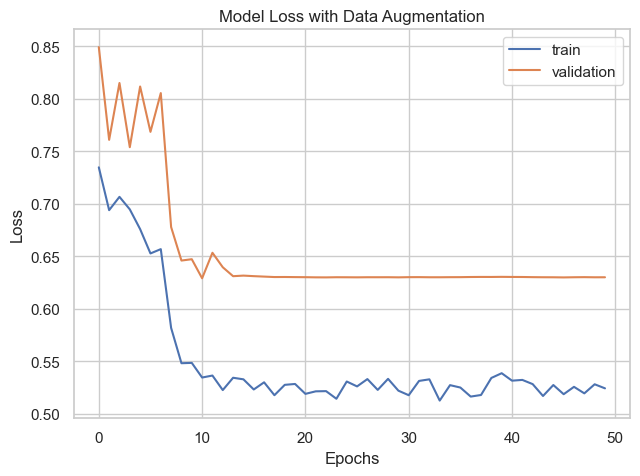

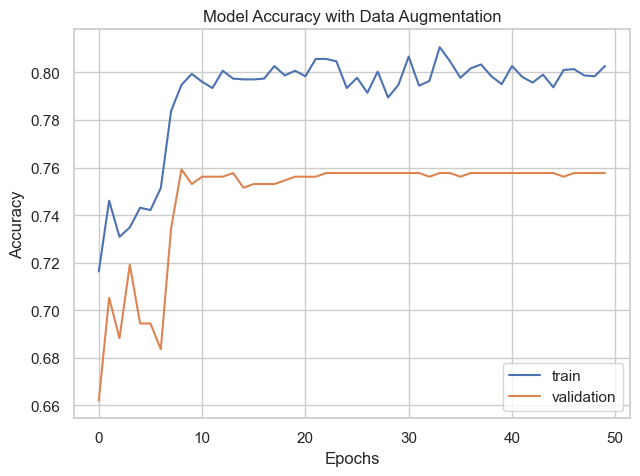

In [98]:
#Evaluating the Model Performance for Experiment 4

# Plot the loss
plt.plot(History_with_data_augmentation.history['loss'])
plt.plot(History_with_data_augmentation.history['val_loss'])
plt.title('Model Loss with Data Augmentation')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Plot the accuracy
plt.plot(History_with_data_augmentation.history['accuracy'])
plt.plot(History_with_data_augmentation.history['val_accuracy'])
plt.title('Model Accuracy with Data Augmentation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [99]:
def display_evaluation_metrics(History_with_data_augmentation, epoch = -1):
    print("The CNN model with batchnormalization has the following performance outcomes for the 50th epoch:\n")
    print("Training accuracy:", History_with_data_augmentation.history['accuracy'][epoch])
    print("Training loss:", History_with_data_augmentation.history['loss'][epoch])
    print("Validation accuracy:", History_with_data_augmentation.history['val_accuracy'][epoch])
    print("Validation loss:", History_with_data_augmentation.history['val_loss'][epoch])

In [100]:
display_evaluation_metrics(History_with_data_augmentation)

The CNN model with batchnormalization has the following performance outcomes for the 50th epoch:

Training accuracy: 0.8027143478393555
Training loss: 0.5243604779243469
Validation accuracy: 0.7577160596847534
Validation loss: 0.630050778388977


In [101]:
#Experiment 5: Experimenting with ResNet 50 Architecture

from keras.applications import ResNet50

# Initialize a new Sequential model
model_resnet50 = Sequential()

# Add the ResNet-50 base model with custom classification layers
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model_resnet50 = keras.Model(inputs=base_model.input, outputs=predictions)

In [102]:
# Compile the model as before
model_resnet50.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_resnet50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 38, 38, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 38, 38, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 38, 38, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 19, 19, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 19, 19, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 19, 19, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 10, 10, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 10, 10, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 10, 10, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 10, 10, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 10, 10, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 10, 10, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 10, 10, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 10, 10, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 10, 10, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 10, 10, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 5, 5, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 5, 5, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 5, 5, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 5, 5, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [103]:
# Fit the ResNet-50 model on the training data
History_resnet50 = model_resnet50.fit(x_train, y_train, batch_size=batch_size,
                                      epochs=5, validation_data=(x_val, y_val),
                                      verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
                                      callbacks=[red_lr])

Epoch 1/5
23/23 [==============================] - 205s 9s/step - loss: 4.1896 - accuracy: 0.2371 - val_loss: 148800673314739585024.0000 - val_accuracy: 0.2500 - lr: 0.0100
Epoch 2/5
23/23 [==============================] - 222s 10s/step - loss: 1.5731 - accuracy: 0.2924 - val_loss: 598340534272.0000 - val_accuracy: 0.1806 - lr: 0.0100
Epoch 3/5
23/23 [==============================] - 215s 9s/step - loss: 1.4795 - accuracy: 0.3294 - val_loss: 76426312.0000 - val_accuracy: 0.2500 - lr: 0.0100
Epoch 4/5
23/23 [==============================] - ETA: 0s - loss: 1.3955 - accuracy: 0.3799
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
23/23 [==============================] - 221s 10s/step - loss: 1.3955 - accuracy: 0.3799 - val_loss: 34828.3047 - val_accuracy: 0.1836 - lr: 0.0100
Epoch 5/5
23/23 [==============================] - 322s 14s/step - loss: 1.3007 - accuracy: 0.4380 - val_loss: 1.6396 - val_accuracy: 0.2500 - lr: 1.0000e-03


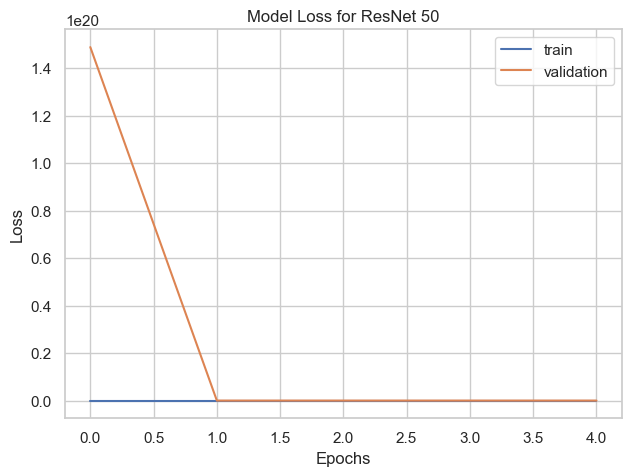

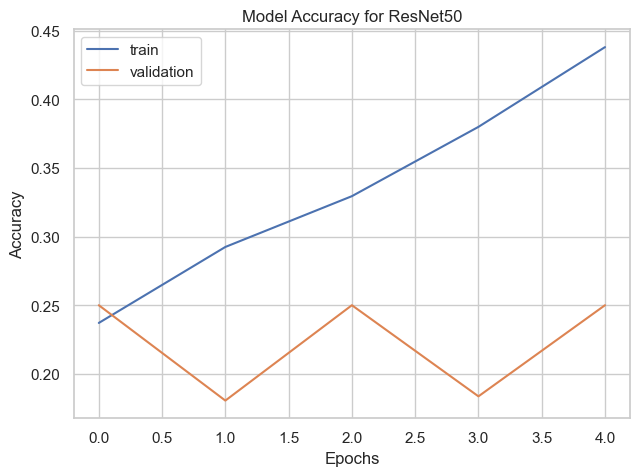

In [104]:
#Evaluating the Model Performance for Experiment 5

# Plot the loss
plt.plot(History_resnet50.history['loss'])
plt.plot(History_resnet50.history['val_loss'])
plt.title('Model Loss for ResNet 50')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Plot the accuracy
plt.plot(History_resnet50.history['accuracy'])
plt.plot(History_resnet50.history['val_accuracy'])
plt.title('Model Accuracy for ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [105]:
def display_evaluation_metrics(History_resnet50, epoch = -1):
    print("The CNN model with ResNet 50 Architecture has the following performance outcomes for the 50th epoch:\n")
    print("Training accuracy:", History_resnet50.history['accuracy'][epoch])
    print("Training loss:", History_resnet50.history['loss'][epoch])
    print("Validation accuracy:", History_resnet50.history['val_accuracy'][epoch])
    print("Validation loss:", History_resnet50.history['val_loss'][epoch])

In [109]:
display_evaluation_metrics(History_resnet50)

The CNN model with ResNet 50 Architecture has the following performance outcomes for the 50th epoch:

Training accuracy: 0.4379536807537079
Training loss: 1.300676941871643
Validation accuracy: 0.25
Validation loss: 1.639563798904419


In [75]:
#Experiment 6: Experimenting with VGG Architecture

from keras.applications import VGG19

# Initialize a new Sequential model
model_vgg19 = Sequential()

# Add the VGG-19 base model with custom classification layers
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model_vgg19 = keras.Model(inputs=base_model.input, outputs=predictions)

In [76]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [77]:
# Compile the model as before
model_vgg19.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model_vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [79]:
# Fit the VGG-19 model on the training data
History_vgg19 = model_vgg19.fit(x_train, y_train, batch_size=batch_size,
                                epochs=3, validation_data=(x_val, y_val),
                                verbose=1, steps_per_epoch=x_train.shape[0] // batch_size,
                                callbacks=[red_lr])

Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 282194.1250 - accuracy: 0.2028 WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 550s 24s/step - loss: 282194.1250 - accuracy: 0.2028 - val_loss: 18.5236 - val_accuracy: 0.1975 - lr: 0.0100
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 85.2306 - accuracy: 0.2136 WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 598s 27s/step - loss: 85.2306 - accuracy: 0.2136 - val_loss: 1.6381 - val_accuracy: 0.1836 - lr: 0.0100
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 8.4187 - accuracy: 0.1977 WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


23/23 [==============================] - 607s 26s/step - loss: 8.4187 - accuracy: 0.1977 - val_loss: 1.6523 - val_accuracy: 0.1806 - lr: 0.0100


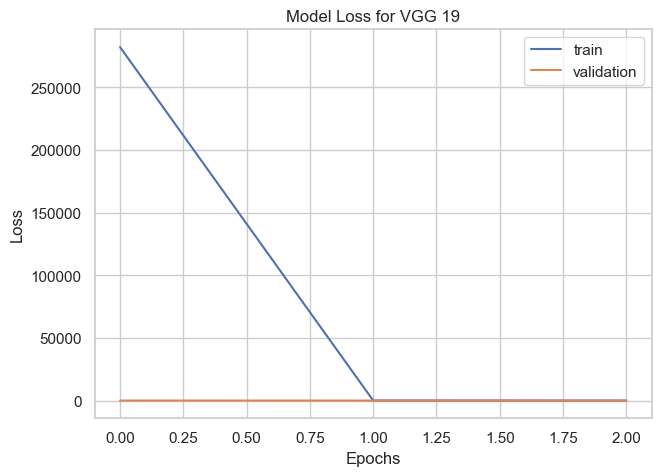

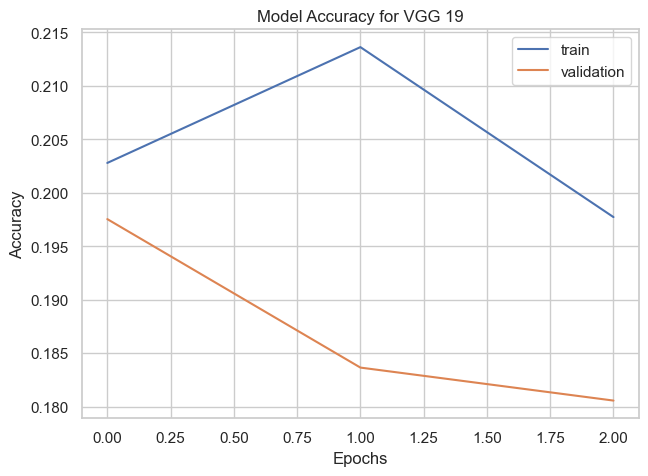

In [80]:
#Evaluating the Model Performance for Experiment 5

# Plot the loss
plt.plot(History_vgg19.history['loss'])
plt.plot(History_vgg19.history['val_loss'])
plt.title('Model Loss for VGG 19')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Plot the accuracy
plt.plot(History_vgg19.history['accuracy'])
plt.plot(History_vgg19.history['val_accuracy'])
plt.title('Model Accuracy for VGG 19')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [81]:
def display_evaluation_metrics(History_vgg19, epoch = -1):
    print("The CNN model with VGG 19 Architecture has the following performance outcomes for the 50th epoch:\n")
    print("Training accuracy:", History_vgg19.history['accuracy'][epoch])
    print("Training loss:", History_vgg19.history['loss'][epoch])
    print("Validation accuracy:", History_vgg19.history['val_accuracy'][epoch])
    print("Validation loss:", History_vgg19.history['val_loss'][epoch])

In [83]:
display_evaluation_metrics(History_vgg19, epoch=2)

The CNN model with VGG 19 Architecture has the following performance outcomes for the 50th epoch:

Training accuracy: 0.19771863520145416
Training loss: 8.41867733001709
Validation accuracy: 0.1805555522441864
Validation loss: 1.6522982120513916


<a id="content5"></a>
## 5 ) Visualizing Predictons on the Test Set

In [108]:
# Test the model
test_score = History_with_data_augmentation.model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", test_score[0])
print("Test accuracy:", test_score[1])

Test loss: 0.5704357624053955
Test accuracy: 0.8040123581886292
